In [1]:
import numpy as np
import networkx as nx
import pandas as pd

from tqdm import tqdm
from itertools import combinations
from scipy import stats
from sklearn import decomposition, preprocessing, manifold
from collections import defaultdict
from annoy import AnnoyIndex
from datetime import datetime as dt

from news_vec.utils import read_json_gz_lines
from news_vec.encoder import read_preds

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [3]:
df = pd.DataFrame(list(tqdm(read_json_gz_lines('../../data/clf-acc-ts-ob.json/'))))

955500it [00:02, 380391.45it/s]


In [4]:
d1s, d2s = zip(*df[['d1', 'd2']].apply(lambda x: sorted(x), 1))
df.drop(['d1', 'd2'], 1)
df['d1'] = d1s
df['d2'] = d2s

In [5]:
pairs = set(map(tuple, df[['d1', 'd2']].values.tolist()))

In [6]:
rows = []
for d1, d2 in tqdm(pairs):
    pdf = df[(df.d1==d1)&(df.d2==d2)].sort_values('window')
    lr = stats.linregress(pdf.window, pdf.acc)
    rows.append((d1, d2, lr.slope, lr.intercept, lr.pvalue, lr.rvalue))

100%|██████████| 105/105 [00:19<00:00,  5.69it/s]


In [7]:
lr_df = pd.DataFrame(rows, columns=('d1', 'd2', 'slope', 'intercept', 'p', 'r'))

In [8]:
tick_labels = [
    dt.fromtimestamp(ts).strftime('%-m/%Y')
    for ts in np.linspace(1483228802, 1537207799, 10, dtype='int')
]

In [9]:
tick_locs = np.linspace(0, len(df.window.unique()), len(tick_labels), dtype='int')

In [18]:
def plot_pairs(lr_df, path, w=8, h=30):

    fig, axes = plt.subplots(len(lr_df), 1, figsize=(w,h), dpi=100)

    for i, r in enumerate(lr_df.itertuples()):

        ax = axes[i]
        pdf = df[(df.d1==r.d1)&(df.d2==r.d2)].sort_values('window')

        fitx = np.array([pdf.window.min(), pdf.window.max()])
        fity = r.slope * fitx + r.intercept

        sns.boxplot(x='window', y='acc', data=pdf, ax=ax)
        ax.plot(fitx, fity, c='black', linewidth=3, alpha=0.7)
        ax.set_xticks(tick_locs)
        ax.set_xticklabels(tick_labels)

        title = f'{r.d1} / {r.d2}'
        ax.set_title(title, fontdict=dict(fontsize=16, fontweight='bold'))
        ax.set_xlabel(None)
        ax.set_ylabel('Accuracy')

    plt.tight_layout(h_pad=2)
    plt.savefig(path)
    plt.show()

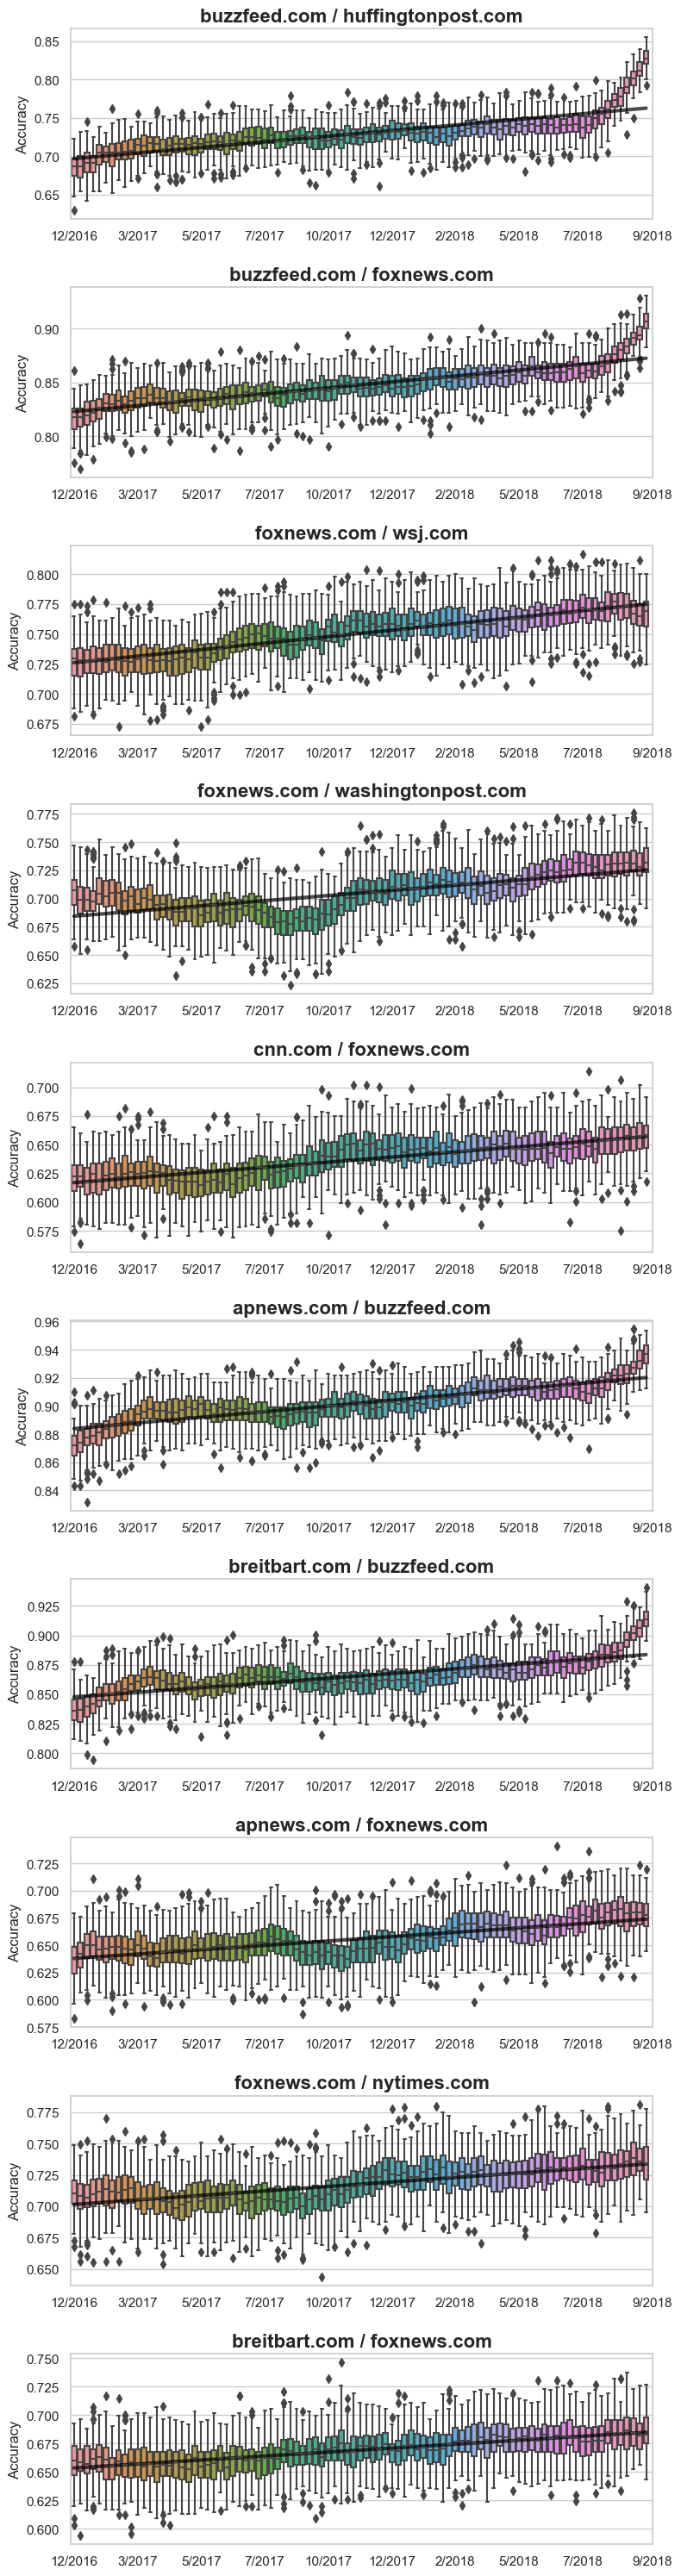

In [19]:
plot_pairs(lr_df.sort_values('slope', ascending=False).head(10), 'figures/ts-ab-rising.png')

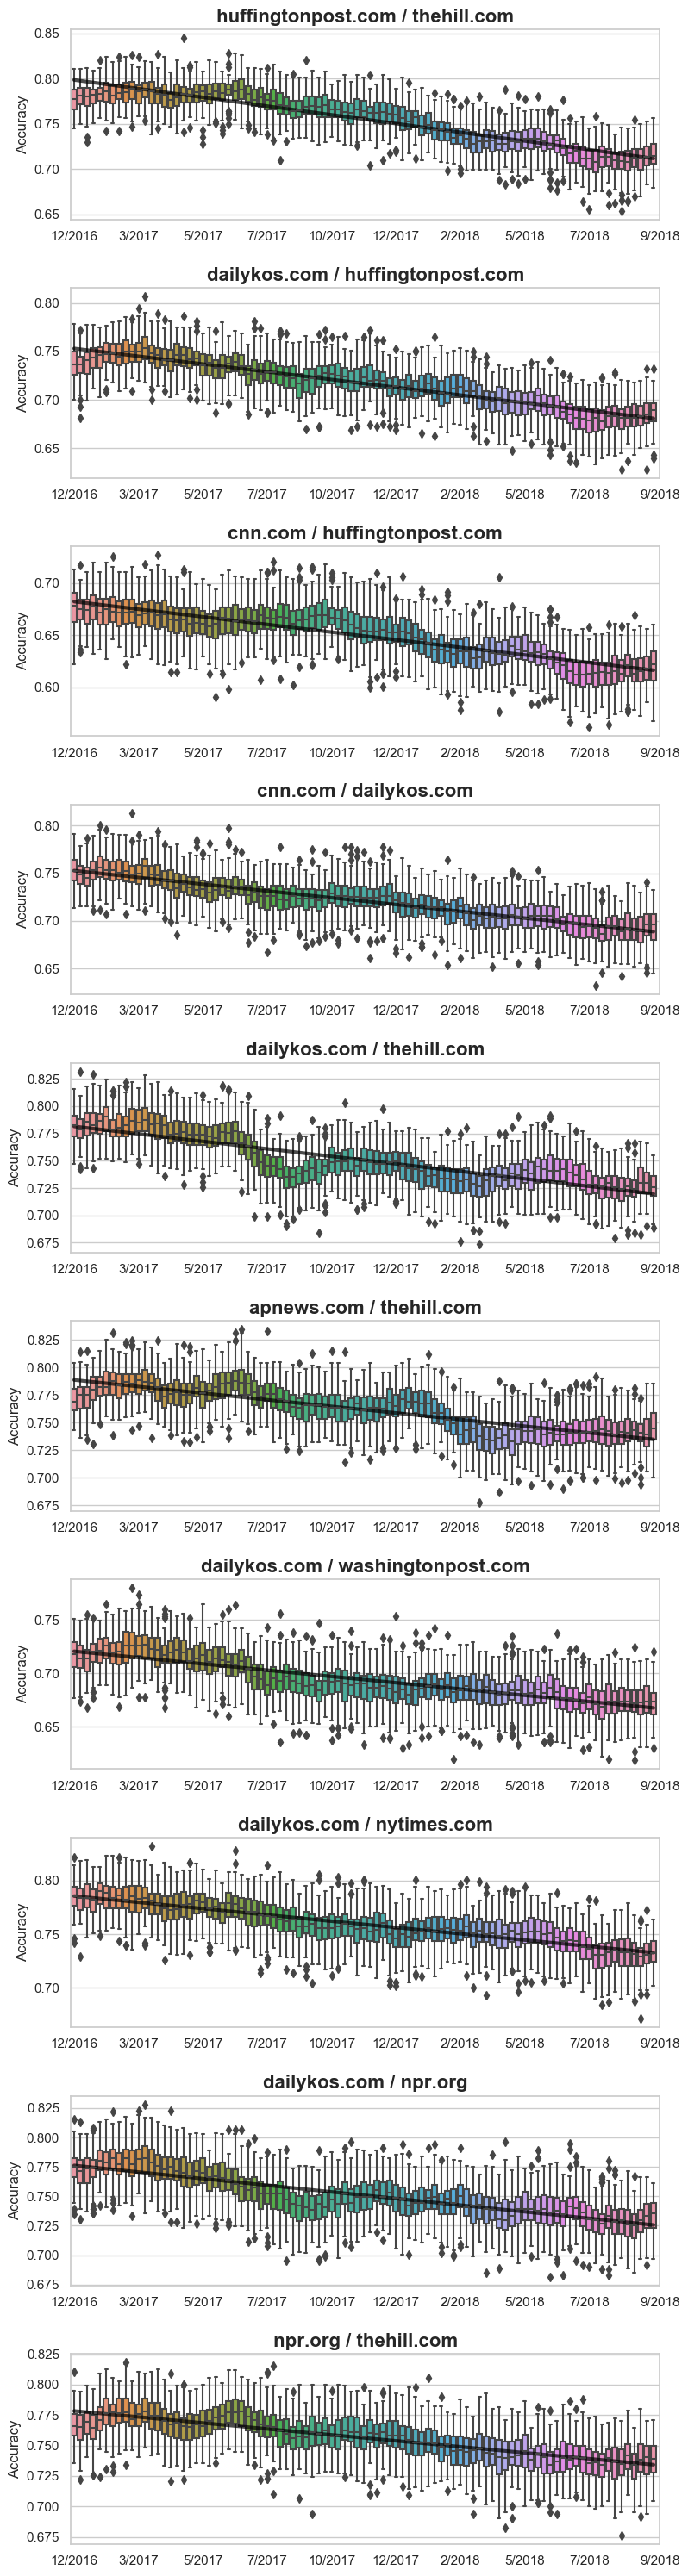

In [20]:
plot_pairs(lr_df.sort_values('slope', ascending=True).head(10), 'figures/ts-ab-falling.png')

In [415]:
lr_df['label'] = lr_df[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

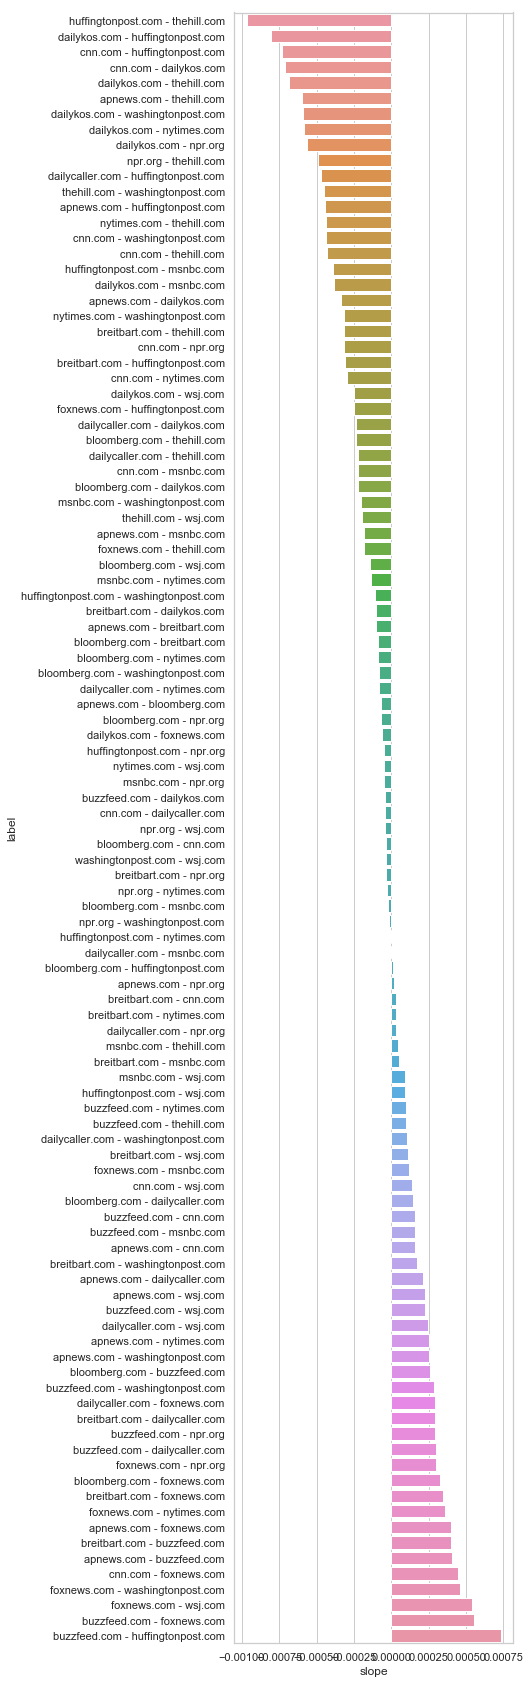

In [418]:
plt.figure(figsize=(5,30))
sns.barplot(x='slope', y='label', data=lr_df.sort_values('slope'))

In [10]:
lr_df['color'] = lr_df.slope.apply(lambda s: 'red' if s > 0 else 'blue')
lr_df['width'] = abs(lr_df.slope*3000)**2

In [16]:
g = nx.Graph()
for r in lr_df.sort_values('slope').itertuples():
    g.add_edge(r.d1, r.d2, width=r.width, color=r.color)

In [17]:
edge_width = [d['width'] for _, _, d in g.edges(data=True)]
edge_color = [d['color'] for _, _, d in g.edges(data=True)]

/Users/dclure/.local/share/virtualenvs/news-vec-AvAtlVxK/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


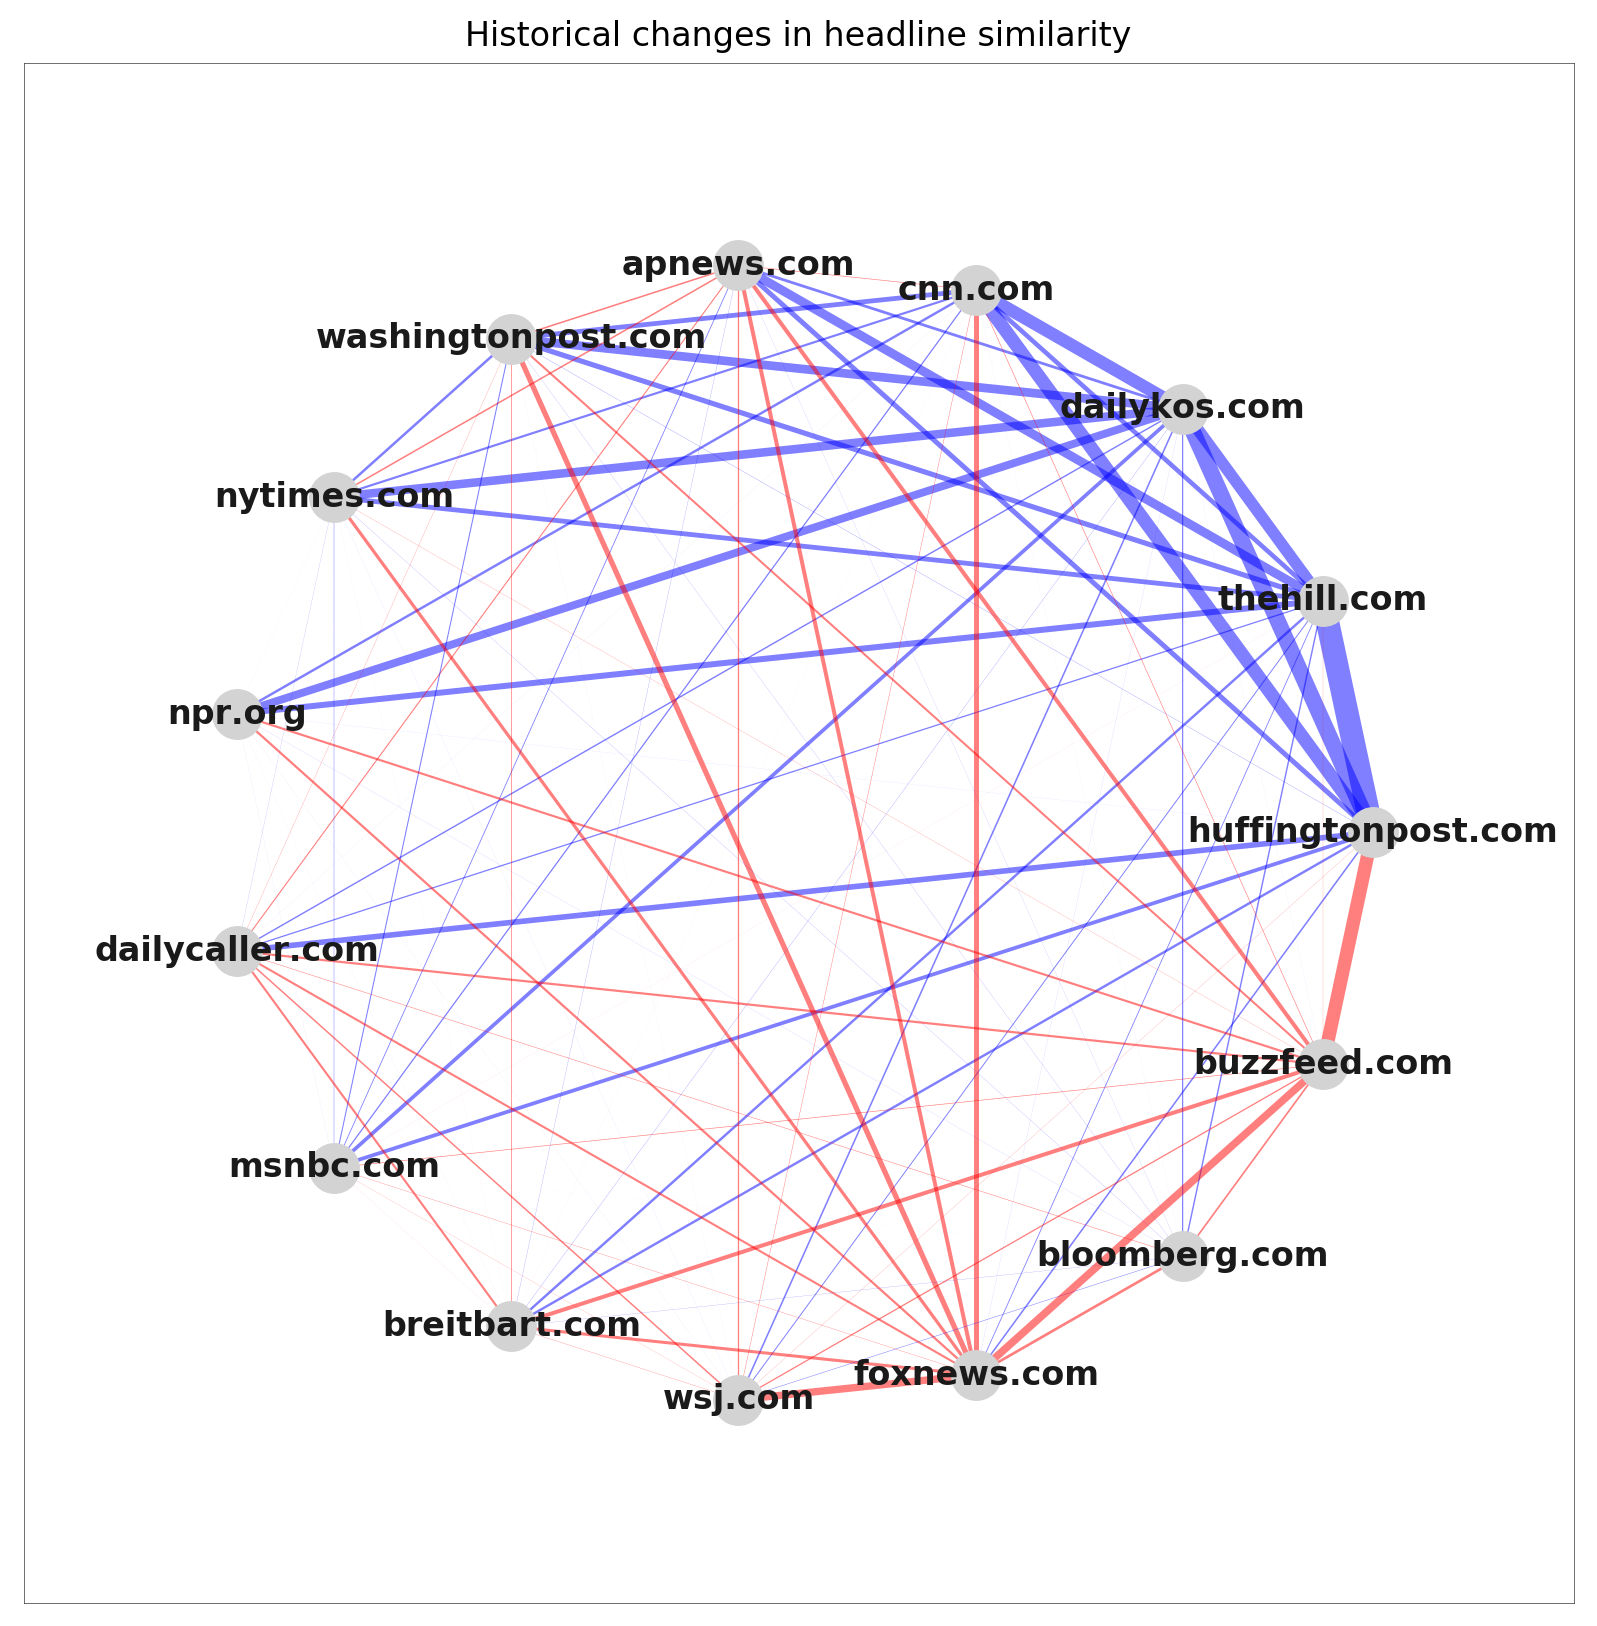

In [68]:
mpl.style.use('default')
plt.figure(figsize=(10,10), dpi=200)
mpl.rc('axes', linewidth=0.2)
plt.xlim(-1.35,1.35)
plt.ylim(-1.35,1.35)
plt.xticks([])
plt.yticks([])
plt.title('Historical changes in headline similarity')
# plt.axis('off')

pos = nx.layout.circular_layout(g)
nx.draw_networkx_nodes(g, pos, node_color='lightgray')
nx.draw_networkx_edges(g, pos, edge_color=edge_color, width=edge_width, alpha=0.5)
_ = nx.draw_networkx_labels(g, pos, font_weight='bold')

plt.savefig('figures/ts-ab-radial.png', bbox_inches='tight')

In [180]:
pred_df, embeds = read_preds('../../data/ava-cnn-big/')

100%|██████████| 283/283 [00:13<00:00, 21.44it/s]


In [181]:
pred_df['wc'] = pred_df.clf_tokens.apply(lambda ts: len(ts))

In [182]:
pred_df['tokens_key'] = pred_df.clf_tokens.apply(lambda ts: tuple(ts))

In [155]:
pred_df = pred_df.drop_duplicates('tokens_key', keep=False)

In [156]:
pred_df_start = pred_df[pred_df.windows.apply(lambda ws: any(np.array(ws) < 10))]
pred_df_end = pred_df[pred_df.windows.apply(lambda ws: any(np.array(ws) > 80))]

In [157]:
idx_start = AnnoyIndex(embeds.shape[1])
for i in pred_df_start.index:
    idx_start.add_item(i, embeds[i])
    
idx_end = AnnoyIndex(embeds.shape[1])
for i in pred_df_end.index:
    idx_end.add_item(i, embeds[i])

In [158]:
idx_start.build(20)
idx_end.build(20)

True

In [161]:
def delta_hls(df1, df2, idx, domain=None, n=10, probe=10000):
    
    v1 = embeds[df1.index].mean(0)
    v2 = embeds[df2.index].mean(0)

    matches = 0
    for i in idx.get_nns_by_vector(v2-v1, probe):
        
        r = pred_df.loc[i]
        
        if not domain or r.domain == domain:
            print(r.title)
#             print('%s --- %s (%d)' % (r.title, r.domain, r.window))
            matches += 1
            if matches == n:
                break

# Buzzfeed

In [162]:
delta_hls(
    pred_df_start[pred_df_start.domain=='buzzfeed.com'],
    pred_df_end[pred_df_end.domain=='buzzfeed.com'],
    idx_end,
    'buzzfeed.com',
)

Build An Over The Top Skillet Cookie And We 'll Reveal Which Foodie Job You Should Have
Cast And Create A Drama Movie In Six Steps And We 'll Tell You Its Score On Rotten Tomatoes
Pick Your First Day Of School Outfit And We 'll Tell You If You 're A Freshman , Sophomore , Junior , Or Senior
Pick Some Colored Shirts And We 'll Reveal Which " The Breakfast Club " Character You 're Most Like
Design Your Dream Home And We 'll Tell You Which Character In " Gilmore Girls " You Are
Answer These Five Questions And We 'll Tell You Which Shrek Character You Are In Bed
Which " To All The Boys I 've Loved Before " And " Mamma Mia ! " Character Are You A Combo Of ?
Describe Your Instagram Habits And We 'll Tell You What Type Of Camp Counselor You Are
Make A Break Up Playlist And We 'll Tell You Which Marvel Superhero You 're Most Compatible With
Dress Head To Toe In Urban Outfitters And We 'll Reveal Which " Riverdale " Character You Are


In [163]:
delta_hls(
    pred_df_end[pred_df_end.domain=='buzzfeed.com'],
    pred_df_start[pred_df_start.domain=='buzzfeed.com'],
    idx_start,
    'buzzfeed.com',
)

Koch Network Focuses On Understanding Trump Voters
Trump Moves To Challenge Vaccine Science
Trump Vineyard Seeks More Foreign Workers
Uber Defends Charging Customers 500 % More For Cars During Tube Strike
Trump Stands By Past Support For Universal Health Care
You 're Stuck With Gogo : Government Reverses Plan For Cell Service On Planes
Activists Prepare To Battle Trump Over Immigrants ' Use Of Public Benefits
Before The Gold Rush : The Legendary Decorator Who Tried ( And Failed ) To Make Trump Tower Tasteful
Company Tied To Trump Campaign Once Pushed For Voter Suppression
Trump Begins Rolling Back Major Obama Water Pollution Rule


# Fox

In [164]:
delta_hls(
    pred_df_start[pred_df_start.domain=='foxnews.com'],
    pred_df_end[pred_df_end.domain=='foxnews.com'],
    idx_end,
    'foxnews.com',
    20
)

How ' The View ' star Joy Behar went from teacher to comic to liberal pundit Trump supporters love to hate
Albanian man reportedly kills 8 relatives over stolen turkeys , sends Facebook message to prime minister before arrest
Missouri nun busted at Sydney airport for smuggling cocaine inside high heels , officials say
ICE rips California county for scrapping contract to house detainees , says move could backfire
4 climbers , including 2 Boy Scouts , found alive after going missing while hiking Mount Baker in Washington
California school district 's ' permissive ' dress code welcoming tube tops , ripped jeans and pajamas sparks debate
North Carolina woman claims she nearly lost leg after contracting serious infection from pedicure
Dramatic video shows moment Florida cop saves little girl from hot car after she was trapped inside for 12 hours
Lena Dunham poses in underwear while giving her support of Cynthia Nixon for NY governor
Peter Strzok , FBI agent pulled from Mueller probe over an

In [165]:
delta_hls(
    pred_df_end[pred_df_end.domain=='foxnews.com'],
    pred_df_start[pred_df_start.domain=='foxnews.com'],
    idx_start,
    'foxnews.com',
    20
)

Alpha by day , beta by night : How to make love last
White House ' Skype ' seats to debut on Wednesday
Has science lost its way ?
Donald Trump plans to undo Dodd Frank law , fiduciary rule
Blind Gamer Wins ' Street Fighter ' Match
ADB : Asian growth seen steady , US policy uncertainty a risk
Tech Q&A : Dealing with Facebook blowhards
Spain arrests Russian hacker sought by US
SoftBank quarterly profit soars on investment empire
Coal mining goes high tech
Inspector general to review pullback of HealthCare.gov ads
Trump policy dims hope for refugees in Indonesian limbo
Trump Starts Over With Tax Plan : Report
Court rules in favor of worker in gig economy lawsuit
US challenge in Syria : Keep allies from fighting one another
Teaching young Americans about money
Evacuations from Syrian water rich region completed
US launches airstrikes in Syria
McMullin faces big election debt amid talk about run for Chaffetz seat
Trump taps Neil Gorsuch to fill Supreme Court vacancy


In [44]:
pred_df_start[pred_df_start.domain=='foxnews.com'].wc.mean()

9.736842105263158

In [46]:
pred_df_end[pred_df_end.domain=='foxnews.com'].wc.mean()

10.94342672413793

breitbart.com


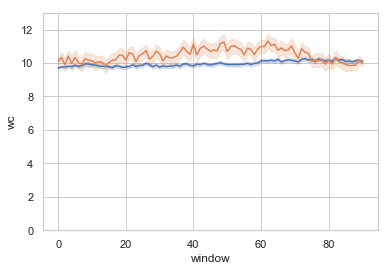

cnn.com


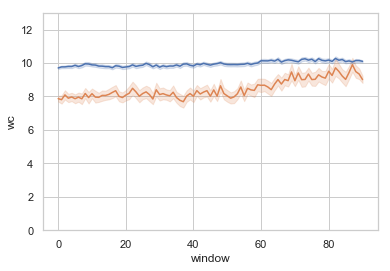

nytimes.com


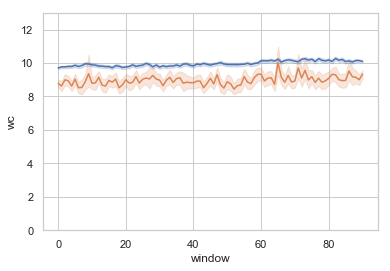

bloomberg.com


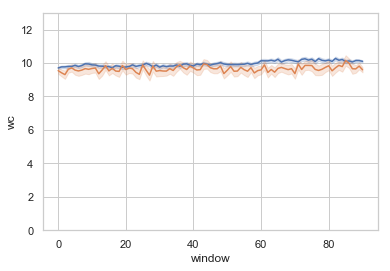

dailycaller.com


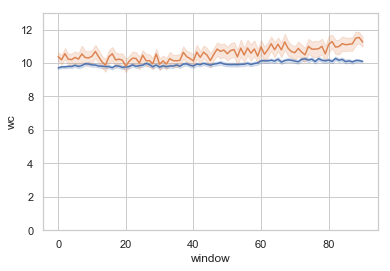

apnews.com


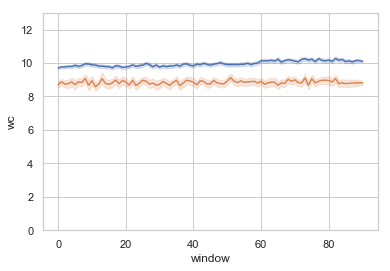

buzzfeed.com


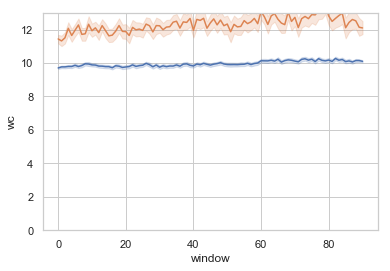

washingtonpost.com


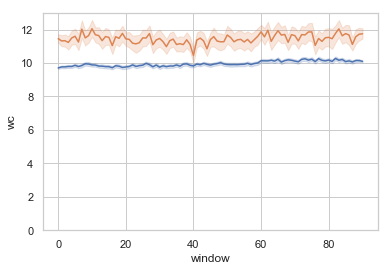

huffingtonpost.com


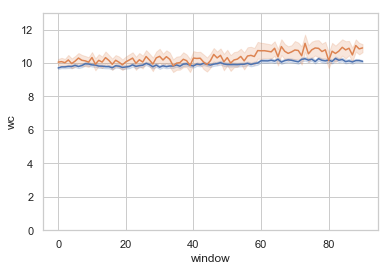

foxnews.com


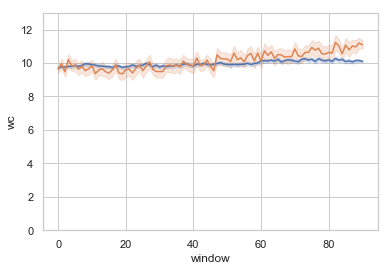

wsj.com


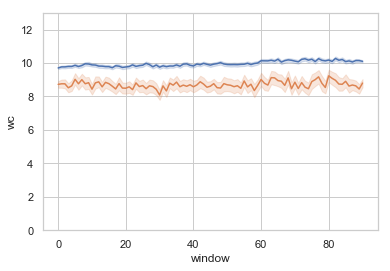

npr.org


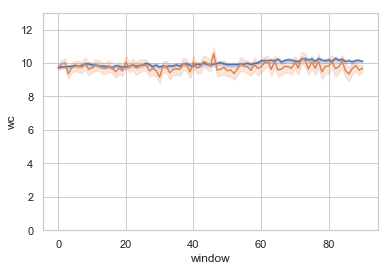

msnbc.com


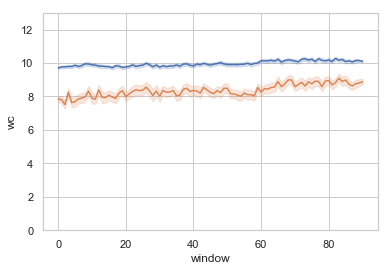

thehill.com


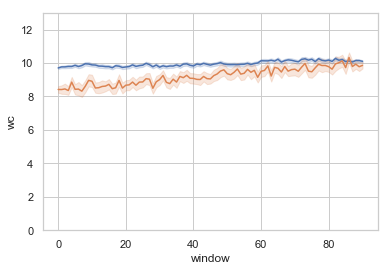

dailykos.com


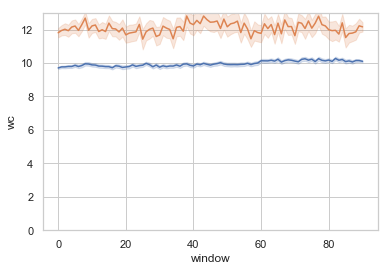

In [56]:
for d in pred_df.domain.unique():
    print(d)
    plt.ylim(0, 13)
    sns.lineplot(x='window', y='wc', data=pred_df)
    sns.lineplot(x='window', y='wc', data=pred_df[pred_df.domain==d])
    plt.show()

In [91]:
hls = list(pred_df[(pred_df.domain=='buzzfeed.com')&(pred_df.windows.apply(lambda ws: any([i in ws for i in range(10)])))]
     .sort_values('p_buzzfeed.com', ascending=False).head(10).title)

for h in hls:
    print(h)

19 Weird AF Tumblr Questions That Actually Kinda Make Sense
Which Cinderella Character Are You ?
16 Times Tumblr Was Fucking Funny About History
Which Celesbian Is Your Soulmate ?
Which Legion Character Are You ?
Literally Just 100 Hilarious Memes About Disney
Which " Shadowhunters " Character Are You ?
Which Potato Food Are You ?
Literally Just 22 Memes That 'll Make Any Australian Crack The Fuck Up
31 Period Jokes That Are Just Really Fucking Funny


In [92]:
hls = list(pred_df[(pred_df.domain=='buzzfeed.com')&(pred_df.windows.apply(lambda ws: any([i in ws for i in range(80,90)])))]
     .sort_values('p_buzzfeed.com', ascending=False).head(10).title)

for h in hls:
    print(h)

Which Underrated Disney Character Are You ?
Which " SpongeBob " Meme Are You ?
Which " Friends " Character Are You ?
Which Marvel Movie Character Are You ?
Which Zodiac Goddess Are You ?
19 Times Tumblr Was Fucking Funny About Periods
Which Iconic Teen Movie Character Are You ?
Which " Stranger Things " Character Are You Actually ?
Which ACOTAR Character Are You ?
33 Ridiculously Cute Products That Will 100 % Melt Your Heart


In [183]:
fox_hls = set(map(tuple, pred_df[pred_df.domain=='foxnews.com'].clf_tokens))

In [184]:
ap_hls = set(map(tuple, pred_df[pred_df.domain=='apnews.com'].clf_tokens))

In [185]:
len(fox_hls.intersection(ap_hls))

250

In [186]:
250/18000

0.013888888888888888

In [128]:
len(pred_df)

282120

In [187]:
pred_df['is_ap'] = pred_df.clf_tokens.apply(lambda ts: tuple(ts) in ap_hls)

In [189]:
pred_df[(pred_df.is_ap==True)].groupby('domain').size()

domain
apnews.com            18808
bloomberg.com            63
breitbart.com            76
cnn.com                  16
dailycaller.com           2
dailykos.com              1
foxnews.com             253
huffingtonpost.com        3
msnbc.com                 5
npr.org                   2
nytimes.com              76
thehill.com               2
washingtonpost.com      168
wsj.com                  12
dtype: int64

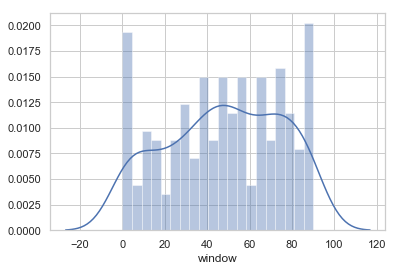

In [194]:
sns.distplot(pred_df[(pred_df.domain=='foxnews.com')&(pred_df.is_ap==True)].window, bins=20)